In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.mlab as mlab

sns.set_context("poster")
%pylab inline
FS, FSS, FSSS = (16, 9), (16, 6), (16, 3)

pd.options.display.float_format = '{:,.4f}'.format

Populating the interactive namespace from numpy and matplotlib


<br/><br/><br/>

## Load the data

In [2]:
dp   = lambda date: pd.datetime.strptime(date, '%d%b%Y')
 
data = pd.read_csv('Example Stocks.csv', parse_dates=['date'], date_parser=dp)

data.columns = list( map( lambda x : x.lower(), data.columns ) )
data['asset'] = data['asset'].apply( lambda x : x.title() )


class Stock:
    def __init__( self, permno, color, data=data ):
        self.permno = permno
        self.color  = color
        self.mask   = (data['permno']==permno)
        self.name   = data[self.mask]['asset'].iloc[0]
        
CocaCola     = Stock( 11308, sns.xkcd_rgb['red']  )
Apple        = Stock( 14593, sns.xkcd_rgb['denim blue'] )
PhilipMorris = Stock( 92602, sns.xkcd_rgb['dark grey'] )
Tesla        = Stock( 93436, sns.xkcd_rgb['teal'] )

all_stocks   = [ Apple, CocaCola, PhilipMorris, Tesla ]
stock_colors = [ x.color for x in all_stocks ]

In [3]:
def plot_returns(stocks, data=data):
    
    if type(stocks) == Stock:
        stocks = [stocks]

    fig, ax1 = plt.subplots(1,1, figsize=FS)
    
    for stock in stocks:
        df = data[ data['permno']==stock.permno ]
        df.plot(
            y='ret', x='date', style=':', marker='o', 
            label=stock.name+' monthly returns', 
            ax=ax1, color= stock.color
               )
        
    legend = plt.legend(frameon=True, loc=0)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.ylim([-0.3,0.3])
    #ax1.axhline(0, linestyle=':', color='grey')

def plot_cumulative(stocks, data=data):
    if type(stocks) == Stock:
        stocks = [stocks]
    fig, (ax1) = plt.subplots(1,1, figsize=FS)
    for stock in stocks:
        df = data[ data['permno']==stock.permno ].set_index('date').copy()
        df['ER' ] = df['ret'].mean()
        df['ret'].cumsum().plot(ax=ax1, label=stock.name +' Cumulative Return', color=stock.color)
        df['ER' ].cumsum().plot(ax=ax1, label=stock.name +' Expected Cumulative Return', style=':', color=stock.color)

    legend = plt.legend(frameon=True, loc=2)
    frame = legend.get_frame()
    frame.set_facecolor('white')

def plot_normal(ax1, mu=0, sigma=0.2, color='b', fixed_range=True):
    
    if fixed_range:
        x = np.linspace(-1, 1, 1000)
    else:
        x = np.linspace(-sigma*3+mu, sigma*3+mu, 1000)
        
    ax1.plot(x, mlab.normpdf(x, mu, sigma), color=color, linestyle='-' )
    
def distribution(stock):
    
    rets    = data[stock.mask]['ret']
    weights = np.ones_like(rets)/len(rets)
    
    df    = sharpe(data)

    mu    = df.ix[stock.name]['ret','mean']
    sigma = df.ix[stock.name]['ret','std' ]

    fig, (ax1) = plt.subplots(1,1,figsize=FS)
    rets.hist(bins=30, ax=ax1, color=stock.color, alpha=0.75, normed=True)

    domain = [x for x in ax1.get_xlim()]
    x = np.linspace(domain[0], domain[1], 100)

    ax1.plot(x, mlab.normpdf(x, mu, sigma), color='k', linestyle='--' )
    ax1.axvline(mu, linestyle=':', color='grey')
    
def plot_sharpe(data, colors=stock_colors):
    df = data.groupby('asset')['ret'].agg( {'ret':[np.mean, np.std]} )
    df['Sharpe'] = df['ret','mean'] / df['ret','std']

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=FSS)
    df['ret'   ].plot( kind='barh', ax=ax1, color=['b','orange'] )
    df['Sharpe'].plot( kind='bar' , ax=ax2, color=colors, rot=20, label='Sharpe Ratio')
    _ = ax2.legend(loc=0)
    

def sharpe(data):
    df = data.groupby('asset')['ret'].agg( {'ret':[np.mean, np.std]} )
    df['Sharpe'] = df['ret','mean'] / df['ret','std']
    return df

<br/><br/><br/>

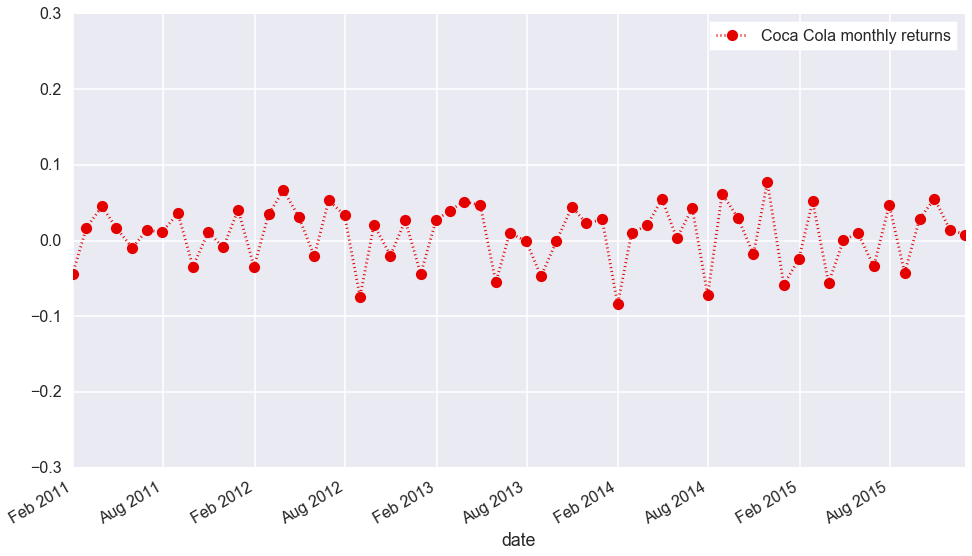

In [4]:
plot_returns( CocaCola )

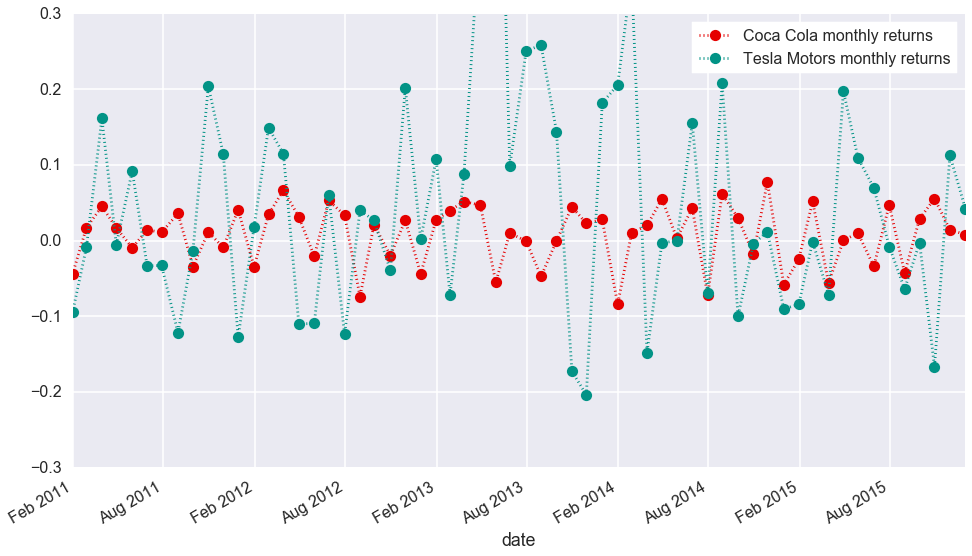

In [5]:
plot_returns( [ CocaCola  ,  Tesla  ] )

<br/><br/><br/>

In [6]:
pf = pd.DataFrame( )
pf['ret'] = data[all_stocks[0].mask].set_index('date')['ret'] * 0.25
for stock in all_stocks[1:]:
    pf['ret'] = pf['ret'] + data[stock.mask].set_index('date')['ret'] * 0.25    
pf['asset' ] = 'Diversified Portfolio'
pf['permno'] = 1

data_pf = data.append( pf.reset_index() )

Portfolio        = Stock( 1, 'purple', data=data_pf )

all_stocks_pf    = [ Apple, CocaCola, Portfolio, PhilipMorris, Tesla ]
stock_colors_pf  = [ x.color for x in all_stocks_pf ]

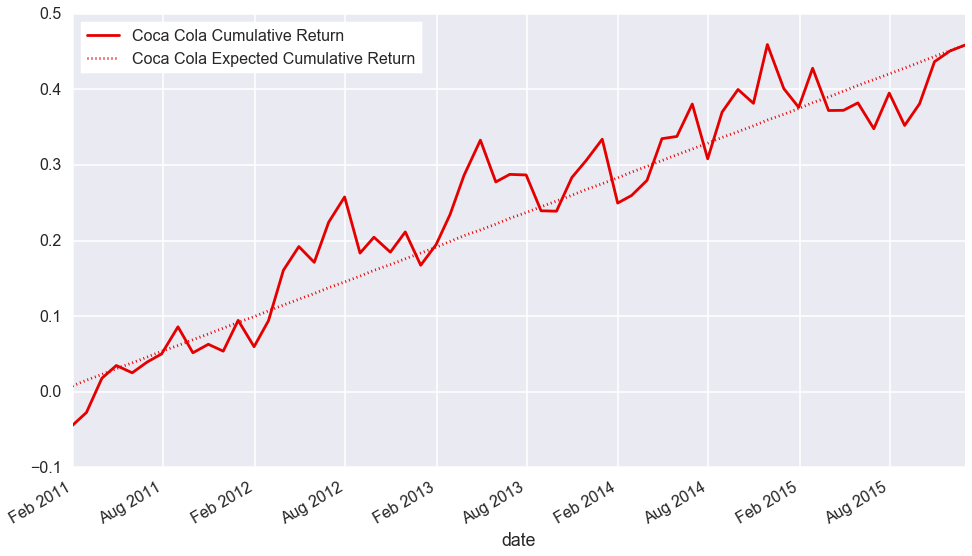

In [7]:
plot_cumulative( CocaCola )

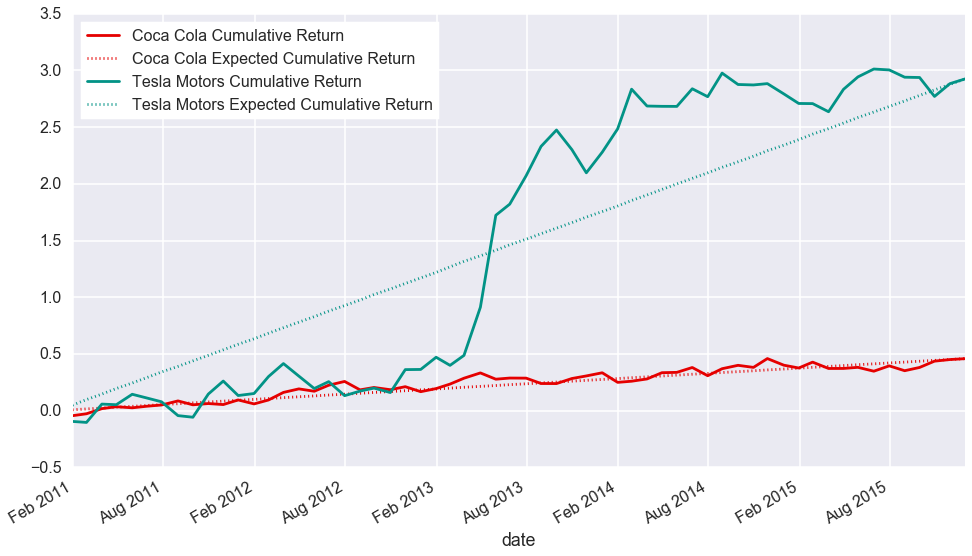

In [8]:
plot_cumulative( [ CocaCola, Tesla ], data=data_pf )

<br/><br/><br/>

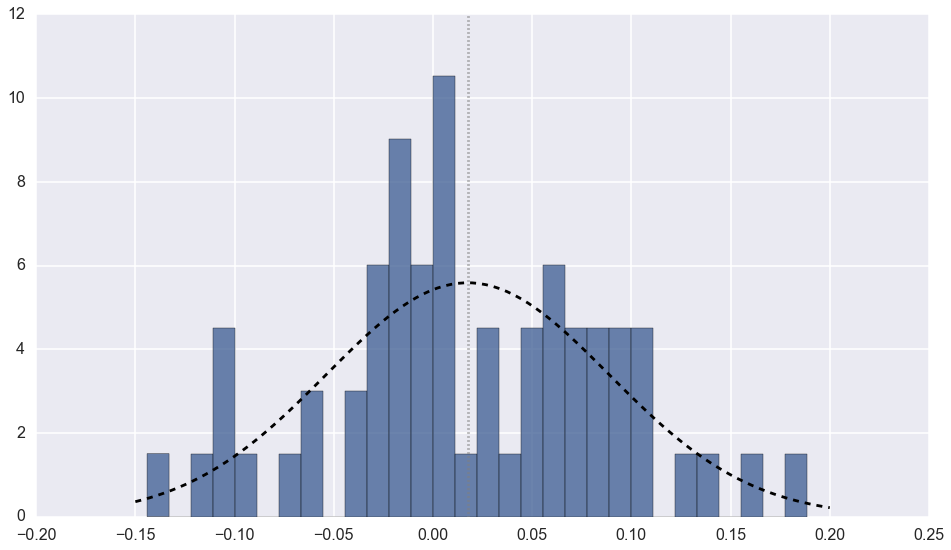

In [14]:
distribution(Apple)

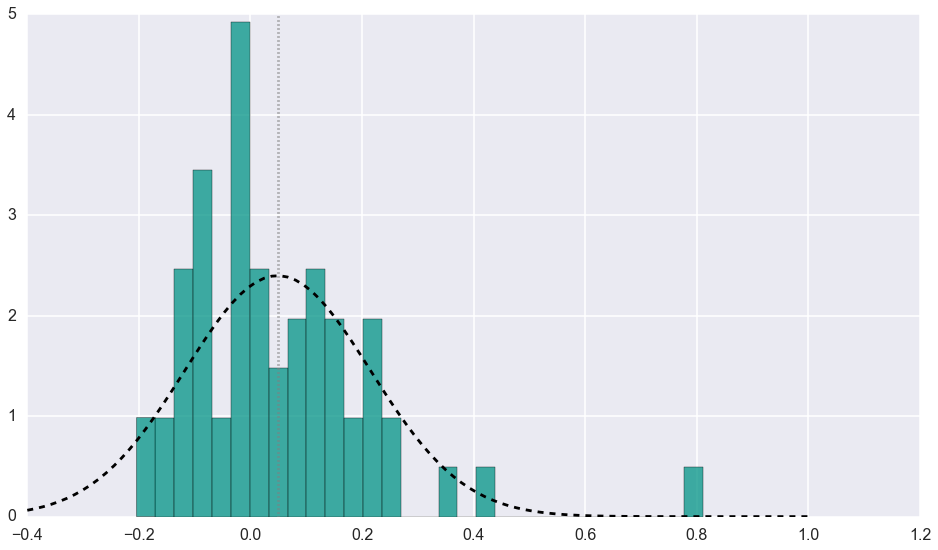

In [15]:
distribution(Tesla)

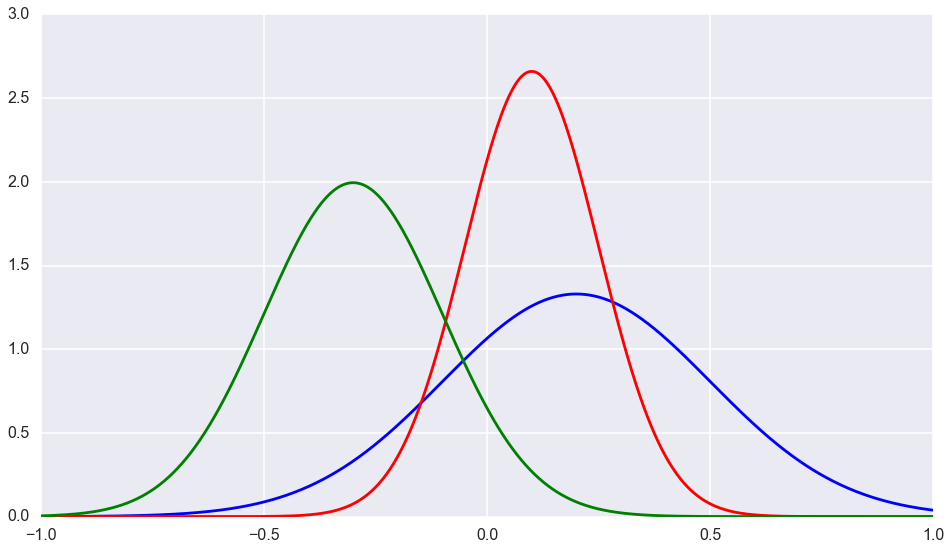

In [10]:
fig, (ax1) = plt.subplots(1,1,figsize=FS)
plot_normal(ax1,  0.2, 0.3 )
plot_normal(ax1,  0.1, 0.15, color='r')
plot_normal(ax1, -0.3, 0.2 , color='g')

<br/><br/><br/>